# Analysis tools

Before we start, we copy the atmospheric setup case from the ["Getting Started"](getting_started.html) example:

First setting up the Radtrans object:

In [1]:
import numpy as np
from petitRADTRANS.radtrans import Radtrans

atmosphere = Radtrans(line_species = ['H2O_HITEMP',
                                      'CO_all_iso_HITEMP',
                                      'CH4',
                                      'CO2',
                                      'Na_burrows',
                                      'K_burrows'],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [0.3, 15])

pressures = np.logspace(-6, 2, 100)
atmosphere.setup_opa_structure(pressures)

  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



<div class="alert alert-warning">

**Units in petitRADTRANS:** remember that all units in *petitRADTRANS* are in cgs, **except for pressure**, which is in bars, **and the mean molecular weight (MMW)**, which is in units of atomic mass units.
</div>

And the atmospheric parameters:

In [2]:
from petitRADTRANS import nat_cst as nc
from petitRADTRANS import physics

R_pl = 1.838*nc.r_jup_mean
gravity = 1e1**2.45
P0 = 0.01

kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.
temperature = physics.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['H2O_HITEMP'] = 0.001 * np.ones_like(temperature)
mass_fractions['CO_all_iso_HITEMP'] = 0.01 * np.ones_like(temperature)
mass_fractions['CO2'] = 0.00001 * np.ones_like(temperature)
mass_fractions['CH4'] = 0.000001 * np.ones_like(temperature)
mass_fractions['Na_burrows'] = 0.00001 * np.ones_like(temperature)
mass_fractions['K_burrows'] = 0.000001 * np.ones_like(temperature)

MMW = 2.33 * np.ones_like(temperature)

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** remember that abundances in petitCODE are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). You can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the mass of a single molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molecular weight, and $n_i$ is the VMR of species $i$.

</div>

## Transmission contribution functions

We calculate the transmission spectrum in the usual way, this time setting the ``contribution = True`` keyword argument, however. This will additionally measure the contribution of the different layers, by calculating as many transmission spectra as there are layers, iteratively turning off the opacity in one layer only. The difference to the nominal transmission spectrum then measures the influence of the respective layers. Note that calculating the contribution function will increase the computation time considerably. We plan to improve the calculation speed of the contribution function soon. The formal definition of the contribution function is (also see Mollière et al., in prep.):

\begin{equation}
C_{\rm tr}^{i} = \frac{R_{\rm nom}^2-R^2(\kappa_i=0)}{\sum_{j=1}^{N_{\rm L}}\left[R_{\rm nom}^2-R^2(\kappa_j=0)\right]},
\end{equation}

where $R_{\rm nom}$ is the nominal transmission radius of the planet and $R(\kappa_i=0)$ is the transmission radius obtained from setting the opacity in the $i$th layer to zero. $N_{\rm L}$ is the number of atmospheric layers.

Now, to the contribution function calculation:

In [3]:
atmosphere.calc_transm(temperature, mass_fractions, \
                       gravity, MMW, R_pl=R_pl, P0_bar=P0, \
                       contribution = True)

The transmission contribution function is plotted below, one can see that pressures above 0.5 bar cannot be probed in the wavelength range studied here.

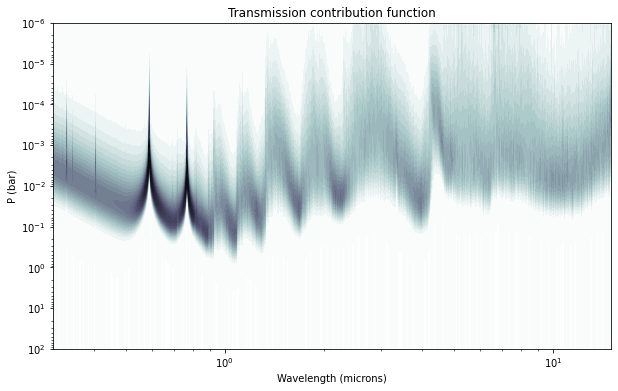

<Figure size 720x432 with 0 Axes>

In [4]:
import pylab as plt

plt.rcParams['figure.figsize'] = (10, 6)

wlen_mu = nc.c/atmosphere.freq/1e-4
X, Y = np.meshgrid(wlen_mu, pressures)
plt.contourf(X,Y,atmosphere.contr_tr,30,cmap=plt.cm.bone_r)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e2,1e-6])
plt.xlim([np.min(wlen_mu),np.max(wlen_mu)])

plt.xlabel('Wavelength (microns)')
plt.ylabel('P (bar)')
plt.title('Transmission contribution function')
plt.show()
plt.clf()

## Emission contribution functions

Below, we show the same for the emission contribution functions, which are defined in the usual way, that is measuring the fraction of flux a layer contributes to the total flux, at a given wavelength. The computational time is comparable to a normal emission spectrum.

In [5]:
atmosphere.calc_flux(temperature, mass_fractions, \
                       gravity, MMW, \
                       contribution = True)

The emission contribution function is plotted below, one can see that pressures that pressures larger than 1 bar can now be probed.

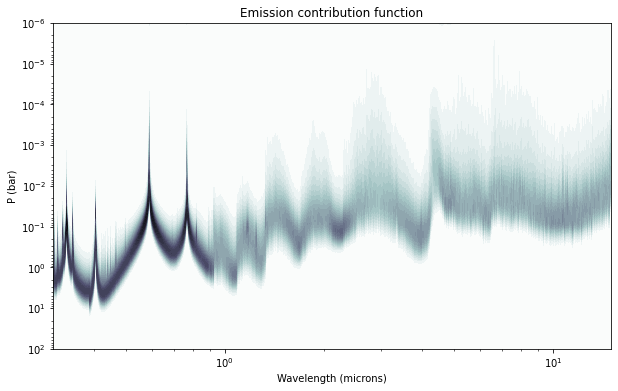

<Figure size 720x432 with 0 Axes>

In [6]:
import pylab as plt

plt.rcParams['figure.figsize'] = (10, 6)

wlen_mu = nc.c/atmosphere.freq/1e-4
X, Y = np.meshgrid(wlen_mu, pressures)
plt.contourf(X,Y,atmosphere.contr_em,30,cmap=plt.cm.bone_r)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e2,1e-6])
plt.xlim([np.min(wlen_mu),np.max(wlen_mu)])

plt.xlabel('Wavelength (microns)')
plt.ylabel('P (bar)')
plt.title('Emission contribution function')
plt.show()
plt.clf()

One also sees that scattering is not included in the pRT emission spectrum here, blueward of the strong alkali lines in the optical, quite large pressures can be probed. Conversely, in the transmission contribution plot above, the Rayleigh scattering is clearly visible. Hence, we will turn on scattering in the calculation below to show its impact on the spectra.

<div class="alert alert-warning">

**Scattering and petitRADTRANS:** remember that scattering is included for emission spectra in petitRADTRANS only if requested specifically when generating the Radtrans object, as it increases the runtime (see ["Scattering for Emission Spectra"](emis_scat.html) for an example how to do this).
</div>

First we reload the pRT object with scattering turned on:

In [7]:
atmosphere = Radtrans(line_species = ['H2O_HITEMP',
                                      'CO_all_iso_HITEMP',
                                      'CH4',
                                      'CO2',
                                      'Na_burrows',
                                      'K_burrows'],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [0.3, 15],
                      do_scat_emis = True)

pressures = np.logspace(-6, 2, 100)
atmosphere.setup_opa_structure(pressures)

  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



Now we recalculate and plot the emission contribution function:

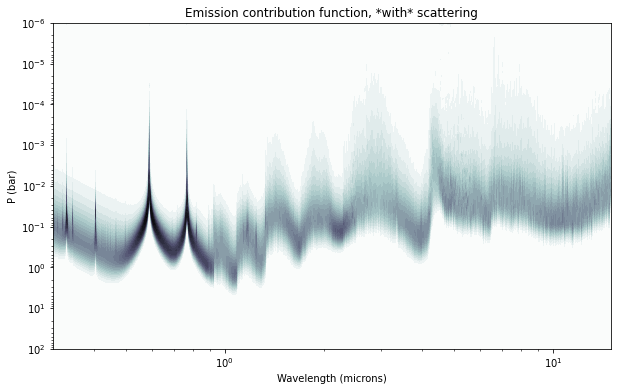

<Figure size 720x432 with 0 Axes>

In [8]:
atmosphere.calc_flux(temperature, mass_fractions, \
                       gravity, MMW, \
                       contribution = True)

import pylab as plt
plt.rcParams['figure.figsize'] = (10, 6)

wlen_mu = nc.c/atmosphere.freq/1e-4
X, Y = np.meshgrid(wlen_mu, pressures)
plt.contourf(X,Y,atmosphere.contr_em,30,cmap=plt.cm.bone_r)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e2,1e-6])
plt.xlim([np.min(wlen_mu),np.max(wlen_mu)])

plt.xlabel('Wavelength (microns)')
plt.ylabel('P (bar)')
plt.title('Emission contribution function, *with* scattering')
plt.show()
plt.clf()

As can be seen, the Rayleigh scattering contribution to the emitted flux leaving the atmosphere is clearly visible now.